# Try do do a 3D registration of the pelvic floor scans
This notebook is *heavily* based on http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/

In [1]:
import platform
import os
import pandas
import glob
from tqdm.auto import tqdm
import dask_image.imread
import imageio
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import napari

In [2]:
# Set up figure defaults
plt.rc('image', cmap='gray', interpolation='nearest')  # Display all images in b&w and with 'nearest' interpolation
plt.rcParams['figure.figsize'] = (16, 9)  # Size up figures a bit
plt.rcParams['figure.dpi'] = 300

In [3]:
# Setup scale bar defaults
plt.rcParams['scalebar.location'] = 'lower right'
plt.rcParams['scalebar.frameon'] = False
plt.rcParams['scalebar.color'] = 'white'

In [4]:
# Different locations if running either on Linux or Windows
FastSSD = True
# to speed things up significantly
if 'Linux' in platform.system():
    if FastSSD:
        BasePath = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
    else:
        BasePath = os.path.join(os.sep, 'home', 'habi', 'research-storage-djonov')
elif 'Darwin' in platform.system():
    # First mount smb://resstore.unibe.ch/ana_rs_djonov/data in the Finder
    FastSSD = False
    BasePath = os.path.join('/Volumes/data/')
elif 'Windows' in platform.system():
    if FastSSD:
        BasePath = os.path.join('F:\\')
    else:
        if 'anaklin' in platform.node():
            BasePath = os.path.join('V:\\')
        else:
            BasePath = os.path.join('V:\\')
Root = os.path.join(BasePath, 'Aaldijk')
print('We are loading all the data from %s' % Root)

We are loading all the data from /media/habi/Fast_SSD/Aaldijk


In [5]:
# Make us a dataframe for saving all that we need
Data = pandas.DataFrame()

In [6]:
# Get *all* log files
Data['LogFile'] = [f for f in sorted(glob.glob(os.path.join(Root, '**', '*.log'), recursive=True))]

In [7]:
# Get *all* log files
Data['LogFile'] = [f for f in sorted(glob.glob(os.path.join(Root, '**', '*.log'), recursive=True))]

In [8]:
# Get all folders
Data['Folder'] = [os.path.dirname(f) for f in Data['LogFile']]

In [9]:
# Check for samples which are not yet reconstructed
for c, row in Data.iterrows():
    # Iterate over every 'proj' folder
    if 'proj' in row.Folder:
        if not 'TScopy' in row.Folder and not 'PR' in row.Folder:
            # If there's nothing with 'rec*' on the same level, then tell us        
            if not glob.glob(row.Folder.replace('proj', '*rec*')):
                print('- %s is missing matching reconstructions' % row.LogFile[len(Root)+1:])

- Foetus02_Lugol_15pct_151d/proj/Foetus02_Lugol_15pct_151d.log is missing matching reconstructions


In [10]:
Data['XYAlignment'] = [glob.glob(os.path.join(f, '*.csv')) for f in Data['Folder']]

In [11]:
# Check for samples which are missing the .csv-files for the XY-alignment
for c, row in Data.iterrows():
    # Iterate over every 'proj' folder
    if 'proj' in row.Folder:
        if not len(row.XYAlignment):
            if not any(x in row.LogFile for x in ['rectmp.log']):
                # 'rectmp.log' because we only exclude it afterwards :)
                print('- %s has *not* been X/Y aligned' % row.LogFile[len(Root)+1:])

- Foetus02_Lugol_15pct_151d/proj/Foetus02_Lugol_15pct_151d.log has *not* been X/Y aligned


In [12]:
# Get rid of all logfiles we don't want
for c, row in Data.iterrows():
    if 'rec' not in row.Folder:  # drop all non-rec folders
        Data.drop([c], inplace=True)
    elif 'SubScan' in row.Folder:  # drop all partial reconstructions which might be there from synchronization
        Data.drop([c], inplace=True)        
    elif 'rectmp.log' in row.LogFile:  # drop all temporary logfiles
        Data.drop([c], inplace=True)
    elif 'Foetus01' in row.LogFile:  # drop this sample, which we don't need
        Data.drop([c], inplace=True)
    elif 'rec_old' in row.LogFile:  # drop the 'old' reconstructions with varying gray values
        Data.drop([c], inplace=True)
# Reset dataframe to something that we would get if we only would have loaded the 'rec' files
Data = Data.reset_index(drop=True)

In [13]:
# Generate us some meaningful colums
Data['Sample'] = [l[len(Root)+1:].split(os.sep)[0] for l in Data['LogFile']]
Data['Scan'] = ['_'.join(l[len(Root)+1:].split(os.sep)[1:-1]) for l in Data['LogFile']]

In [14]:
# Get the file names of the reconstructions
Data['Reconstructions'] = [sorted(glob.glob(os.path.join(f, '*rec0*.png'))) for f in Data['Folder']]
Data['Number of reconstructions'] = [len(r) for r in Data.Reconstructions]

In [15]:
def get_pixelsize(logfile):
    """Get the pixel size from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Image Pixel' in line and 'Scaled' not in line:
                pixelsize = float(line.split('=')[1])
    return(pixelsize)

In [16]:
Data['Voxelsize'] = [get_pixelsize(log) for log in Data['LogFile']]

In [17]:
# Load all reconstructions into ephemereal DASK arrays
Reconstructions = [None] * len(Data)
for c, row in tqdm(Data.iterrows(),
                   desc='Load reconstructions',
                   total=len(Data)):
    Reconstructions[c] = dask_image.imread.imread(os.path.join(row['Folder'],
                                                               '*rec*.png'))

Load reconstructions:   0%|          | 0/16 [00:00<?, ?it/s]

In [18]:
Data

,LogFile,Folder,XYAlignment,Sample,Scan,Reconstructions,Number of reconstructions,Voxelsize
0,/media/habi/Fast_SSD/Aaldijk/Foetus02/rec/Foet...,/media/habi/Fast_SSD/Aaldijk/Foetus02/rec,[],Foetus02,rec,[/media/habi/Fast_SSD/Aaldijk/Foetus02/rec/Foe...,1941,20.000477
1,/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_05...,/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_05...,[],Foetus02_Lugol_05pct_007d,rec,[/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_0...,1941,20.000477
2,/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_10...,/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_10...,[],Foetus02_Lugol_10pct_014d,rec,[/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_1...,1941,20.000477
3,/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_10...,/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_10...,[],Foetus02_Lugol_10pct_025d,rec,[/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_1...,1941,20.000477
4,/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_15...,/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_15...,[],Foetus02_Lugol_15pct_044d,rec,[/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_1...,1941,20.000477
5,/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_15...,/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_15...,[],Foetus02_Lugol_15pct_053d,rec,[/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_1...,1941,20.000477
6,/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_15...,/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_15...,[],Foetus02_Lugol_15pct_060d,rec,[/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_1...,1941,20.000477
7,/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_15...,/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_15...,[],Foetus02_Lugol_15pct_070d,rec,[/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_1...,1941,20.000477
8,/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_15...,/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_15...,[],Foetus02_Lugol_15pct_077d,rec,[/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_1...,1941,20.000477
9,/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_15...,/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_15...,[],Foetus02_Lugol_15pct_088d,rec,[/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_1...,1941,20.000477


In [19]:
# View it in 3D
# viewer = napari.view_image(Reconstructions[14][::4,::4,::4])

In [20]:
# How big are the datasets?
Data['Size'] = [rec.shape for rec in Reconstructions]

In [21]:
# The three cardinal directions
directions = ['Axial',
              'Coronal',
              'Sagittal']

In [22]:
# Read or calculate the middle slices, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['Mid_' + direction] = [None] * len(Reconstructions)
for c, row in tqdm(Data.iterrows(), desc='Middle images', total=len(Data), leave=False):
    for d, direction in tqdm(enumerate(directions),
                             desc='%s/%s' % (row['Sample'], row['Scan']),
                             leave=False,
                             total=len(directions)):
        outfilepath = os.path.join(os.path.dirname(row['Folder']),
                                   '%s.%s.Middle.%s.png' % (row['Sample'],
                                                            row['Scan'],
                                                            direction))
        if os.path.exists(outfilepath):
            Data.at[c, 'Mid_' + direction] = dask_image.imread.imread(outfilepath)
        else:
            # Generate requested axial view
            if 'Axial' in direction:
                Data.at[c, 'Mid_' + direction] = Reconstructions[c][Data['Size'][c][0] // 2].squeeze()[:,:,1]
            if 'Sagittal' in direction:
                Data.at[c, 'Mid_' + direction] = Reconstructions[c][:, Data['Size'][c][1] // 2, :].squeeze()[:,:,1]
            if 'Coronal' in direction:
                Data.at[c, 'Mid_' + direction] = Reconstructions[c][:, :, Data['Size'][c][2] // 2].squeeze()[:,:,1]
            # Save the calculated 'direction' view to disk           
            imageio.imwrite(outfilepath, Data.at[c, 'Mid_' + direction].astype('uint8'))

Middle images:   0%|          | 0/16 [00:00<?, ?it/s]

Foetus02/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Foetus02_Lugol_05pct_007d/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Foetus02_Lugol_10pct_014d/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Foetus02_Lugol_10pct_025d/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Foetus02_Lugol_15pct_044d/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Foetus02_Lugol_15pct_053d/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Foetus02_Lugol_15pct_060d/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Foetus02_Lugol_15pct_070d/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Foetus02_Lugol_15pct_077d/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Foetus02_Lugol_15pct_088d/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Foetus02_Lugol_15pct_098d/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Foetus02_Lugol_15pct_108d/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Foetus02_Lugol_15pct_108d/rec_11um:   0%|          | 0/3 [00:00<?, ?it/s]

Foetus02_Lugol_15pct_141d/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Foetus02_Lugol_15pct_152d/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Foetus02_Lugol_15pct_152d/rec_11um:   0%|          | 0/3 [00:00<?, ?it/s]

In [23]:
# Read or calculate the directional MIPs, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['MIP_' + direction] = [None] * len(Reconstructions)
for c, row in tqdm(Data.iterrows(), desc='MIPs', total=len(Data), leave=False):
    for d, direction in tqdm(enumerate(directions),
                             desc='%s/%s' % (row['Sample'], row['Scan']),
                             leave=False,
                             total=len(directions)):
        outfilepath = os.path.join(os.path.dirname(row['Folder']),
                                   '%s.%s.MIP.%s.png' % (row['Sample'],
                                                      row['Scan'],
                                                      direction))
        if os.path.exists(outfilepath):
            Data.at[c, 'MIP_' + direction] = dask_image.imread.imread(outfilepath).squeeze()
        else:
            # Generate MIP
            Data.at[c, 'MIP_' + direction] = Reconstructions[c].max(axis=d).compute()
            # Save it out
            imageio.imwrite(outfilepath, Data.at[c, 'MIP_' + direction].astype('uint8'))

MIPs:   0%|          | 0/16 [00:00<?, ?it/s]

Foetus02/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Foetus02_Lugol_05pct_007d/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Foetus02_Lugol_10pct_014d/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Foetus02_Lugol_10pct_025d/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Foetus02_Lugol_15pct_044d/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Foetus02_Lugol_15pct_053d/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Foetus02_Lugol_15pct_060d/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Foetus02_Lugol_15pct_070d/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Foetus02_Lugol_15pct_077d/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Foetus02_Lugol_15pct_088d/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Foetus02_Lugol_15pct_098d/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Foetus02_Lugol_15pct_108d/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Foetus02_Lugol_15pct_108d/rec_11um:   0%|          | 0/3 [00:00<?, ?it/s]

Foetus02_Lugol_15pct_141d/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Foetus02_Lugol_15pct_152d/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Foetus02_Lugol_15pct_152d/rec_11um:   0%|          | 0/3 [00:00<?, ?it/s]

----
Actually start the registration now

----

In [24]:
import SimpleITK as sitk
from downloaddata import fetch_data as fdata

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import clear_output

# Callback invoked by the interact IPython method for scrolling through the image stacks of
# the two images (moving and fixed).
def display_images(fixed_image_z, moving_image_z, fixed_npa, moving_npa):
    # Create a figure with two subplots and the specified size.
    plt.subplots(1, 2, figsize=(10, 8))

    # Draw the fixed image in the first subplot.
    plt.subplot(1, 2, 1)
    plt.imshow(fixed_npa[fixed_image_z, :, :], cmap=plt.cm.Greys_r)
    plt.title("fixed image")
    plt.axis("off")

    # Draw the moving image in the second subplot.
    plt.subplot(1, 2, 2)
    plt.imshow(moving_npa[moving_image_z, :, :], cmap=plt.cm.Greys_r)
    plt.title("moving image")
    plt.axis("off")

    plt.show()

# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space.
def display_images_with_alpha(image_z, alpha, fixed, moving):
    img = (1.0 - alpha) * fixed[:, :, image_z] + alpha * moving[:, :, image_z]
    plt.imshow(sitk.GetArrayViewFromImage(img), cmap=plt.cm.Greys_r)
    plt.axis("off")
    plt.show()

# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations

    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations

    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method):
    global metric_values, multires_iterations

    metric_values.append(registration_method.GetMetricValue())
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, "r")
    plt.plot(
        multires_iterations,
        [metric_values[index] for index in multires_iterations],
        "b*",
    )
    plt.xlabel("Iteration Number", fontsize=12)
    plt.ylabel("Metric Value", fontsize=12)
    plt.show()

# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the
# metric_values list.
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))

In [ ]:
# Drop high-resolution scans, e.g. only register the quick ones...
Data.Voxelsize.unique()

In [26]:
# Get *our* images into SimpleITK
downsample = 2
fixed_image = sitk.GetImageFromArray(Reconstructions[11][::downsample,::downsample,::downsample])##.compute())
moving_image = sitk.GetImageFromArray(Reconstructions[13][::downsample,::downsample,::downsample])##.compute())

In [27]:
fixed_image.GetSize()

(1536, 1536, 971)

In [28]:
# Read SimpleITK images
# fixed_image = sitk.ReadImage(fdata("training_001_ct.mha"), sitk.sitkFloat32)
# moving_image = sitk.ReadImage(fdata("training_001_mr_T1.mha"), sitk.sitkFloat32)

In [29]:
# # Show the images
# interact(
#     display_images,
#     fixed_image_z=(0, fixed_image.GetSize()[2] - 1),
#     moving_image_z=(0, moving_image.GetSize()[2] - 1),
#     fixed_npa=fixed(sitk.GetArrayViewFromImage(fixed_image)),
#     moving_npa=fixed(sitk.GetArrayViewFromImage(moving_image)),
# );

In [30]:
initial_transform = sitk.CenteredTransformInitializer(
    fixed_image,
    moving_image,
    sitk.Euler3DTransform(),
    sitk.CenteredTransformInitializerFilter.GEOMETRY,
)

# moving_resampled = sitk.Resample(
#     moving_image,
#     fixed_image,
#     initial_transform,
#     sitk.sitkLinear,
#     0.0,
#     moving_image.GetPixelID(),
# )

# # Compare images
# interact(
#     display_images_with_alpha,
#     image_z=(0, fixed_image.GetSize()[2] - 1),
#     alpha=(0.0, 1.0, 1),
#     fixed=fixed(fixed_image),
#     moving=fixed(moving_image),
# );

interactive(children=(IntSlider(value=485, description='image_z', max=970), FloatSlider(value=0.0, description…

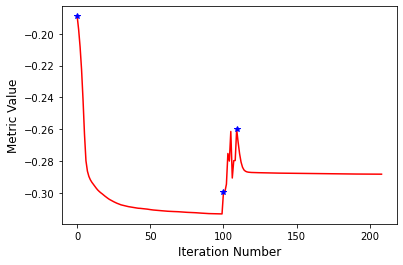

In [40]:
registration_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)

registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
registration_method.SetOptimizerAsGradientDescent(
    learningRate=1.0,
    numberOfIterations=100,
    convergenceMinimumValue=1e-6,
    convergenceWindowSize=10,
)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.
registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2, 1, 0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times.
registration_method.SetInitialTransform(initial_transform, inPlace=False)

# Connect all of the observers so that we can perform plotting during registration.
registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method.AddCommand(
    sitk.sitkMultiResolutionIterationEvent, update_multires_iterations
)
registration_method.AddCommand(
    sitk.sitkIterationEvent, lambda: plot_values(registration_method)
)

final_transform = registration_method.Execute(
    sitk.Cast(fixed_image, sitk.sitkFloat32), sitk.Cast(moving_image, sitk.sitkFloat32)
)

In [41]:
print(f"Final metric value: {registration_method.GetMetricValue()}")
print(f"Optimizer's stopping condition, {registration_method.GetOptimizerStopConditionDescription()}")

Final metric value: -0.2882524433220624
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Maximum number of iterations (100) exceeded.


In [42]:
moving_resampled = sitk.Resample(
    moving_image,
    fixed_image,
    final_transform,
    sitk.sitkLinear,
    0.0,
    moving_image.GetPixelID(),
)

# # Look at registration
# interact(
#     display_images_with_alpha,
#     image_z=(0, fixed_image.GetSize()[2] - 1),
#     alpha=(0.0, 1.0, 1),
#     fixed=fixed(fixed_image),
#     moving=fixed(moving_resampled),
# );

In [43]:
OUTPUT_DIR = "Output"

In [44]:
# fixed_image = sitk.GetImageFromArray(Reconstructions[11][::downsample,::downsample,::downsample])##.compute())
# moving_image = sitk.GetImageFromArray(Reconstructions[13][::downsample,::downsample,::downsample])##.compute())

In [45]:
Data.Sample[11]

'Foetus02_Lugol_15pct_108d'

In [46]:
downsample

2

In [47]:
print(os.path.join(os.path.dirname(Data.Folder[11]),
                                   Data.Sample[11] + "_registered_with_" + Data.Sample[11] + "_downsampled" + str(downsample) + "x.tif") )  

/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_15pct_108d/Foetus02_Lugol_15pct_108d_registered_with_Foetus02_Lugol_15pct_108d_downsampled2x.tif


In [48]:
print(os.path.join(os.path.dirname(Data.Folder[13]),
                              Data.Sample[13] + "_downsampled_" + str(downsample) + "x.tif"))

/media/habi/Fast_SSD/Aaldijk/Foetus02_Lugol_15pct_141d/Foetus02_Lugol_15pct_141d_downsampled_2x.tif


In [ ]:
# Output what we did
# sitk.WriteImage(
#     moving_image, os.path.join(OUTPUT_DIR, "moving_image.tif")
# )
sitk.WriteImage(moving_resampled,
                os.path.join(os.path.dirname(Data.Folder[11]),
                             Data.Sample[11] + "_registered_with_" + Data.Sample[11] + "_downsampled" + str(downsample) + "x.tif"))
sitk.WriteImage(fixed_image,
                os.path.join(os.path.dirname(Data.Folder[13]),
                             Data.Sample[13] + "_downsampled_" + str(downsample) + "x.tif"))

In [ ]:
moving_image

In [36]:
moving_image

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7f1ef9c8d4e0> >

In [38]:
import skimage

In [46]:
image = Data.MIP_Axial[11]
moving_image = Data.MIP_Axial[13]

In [47]:
v, u = skimage.registration.optical_flow_tvl1(image,  moving_image)

In [43]:
v

array([[ 1.7869638,  1.7869713,  1.786986 , ...,  7.754812 ,  7.754606 ,
         7.7545023],
       [ 1.7869601,  1.7869675,  1.7869823, ...,  7.754816 ,  7.75461  ,
         7.754507 ],
       [ 1.7869525,  1.78696  ,  1.7869747, ...,  7.7548223,  7.754619 ,
         7.754516 ],
       ...,
       [10.341952 , 10.341984 , 10.342041 , ...,  1.200803 ,  1.2057854,
         1.2034448],
       [10.341982 , 10.3420105, 10.3420725, ...,  1.2053242,  1.2029749,
         1.2043357],
       [10.341996 , 10.342027 , 10.342085 , ...,  1.2033854,  1.2042814,
         1.2039171]], dtype=float32)

In [44]:
u

array([[ -77.35168 ,  -77.351585,  -77.3514  , ...,  -64.26188 ,
         -64.264885,  -64.266556],
       [ -77.35171 ,  -77.351616,  -77.35145 , ...,  -64.26193 ,
         -64.26494 ,  -64.26661 ],
       [ -77.35178 ,  -77.35169 ,  -77.35152 , ...,  -64.26204 ,
         -64.265045,  -64.26672 ],
       ...,
       [-138.03032 , -138.0304  , -138.03052 , ..., -106.97527 ,
        -106.97602 , -106.97347 ],
       [-138.03044 , -138.03049 , -138.03065 , ..., -106.97592 ,
        -106.97667 , -106.97345 ],
       [-138.03049 , -138.03056 , -138.0307  , ..., -106.97564 ,
        -106.97673 , -106.97362 ]], dtype=float32)

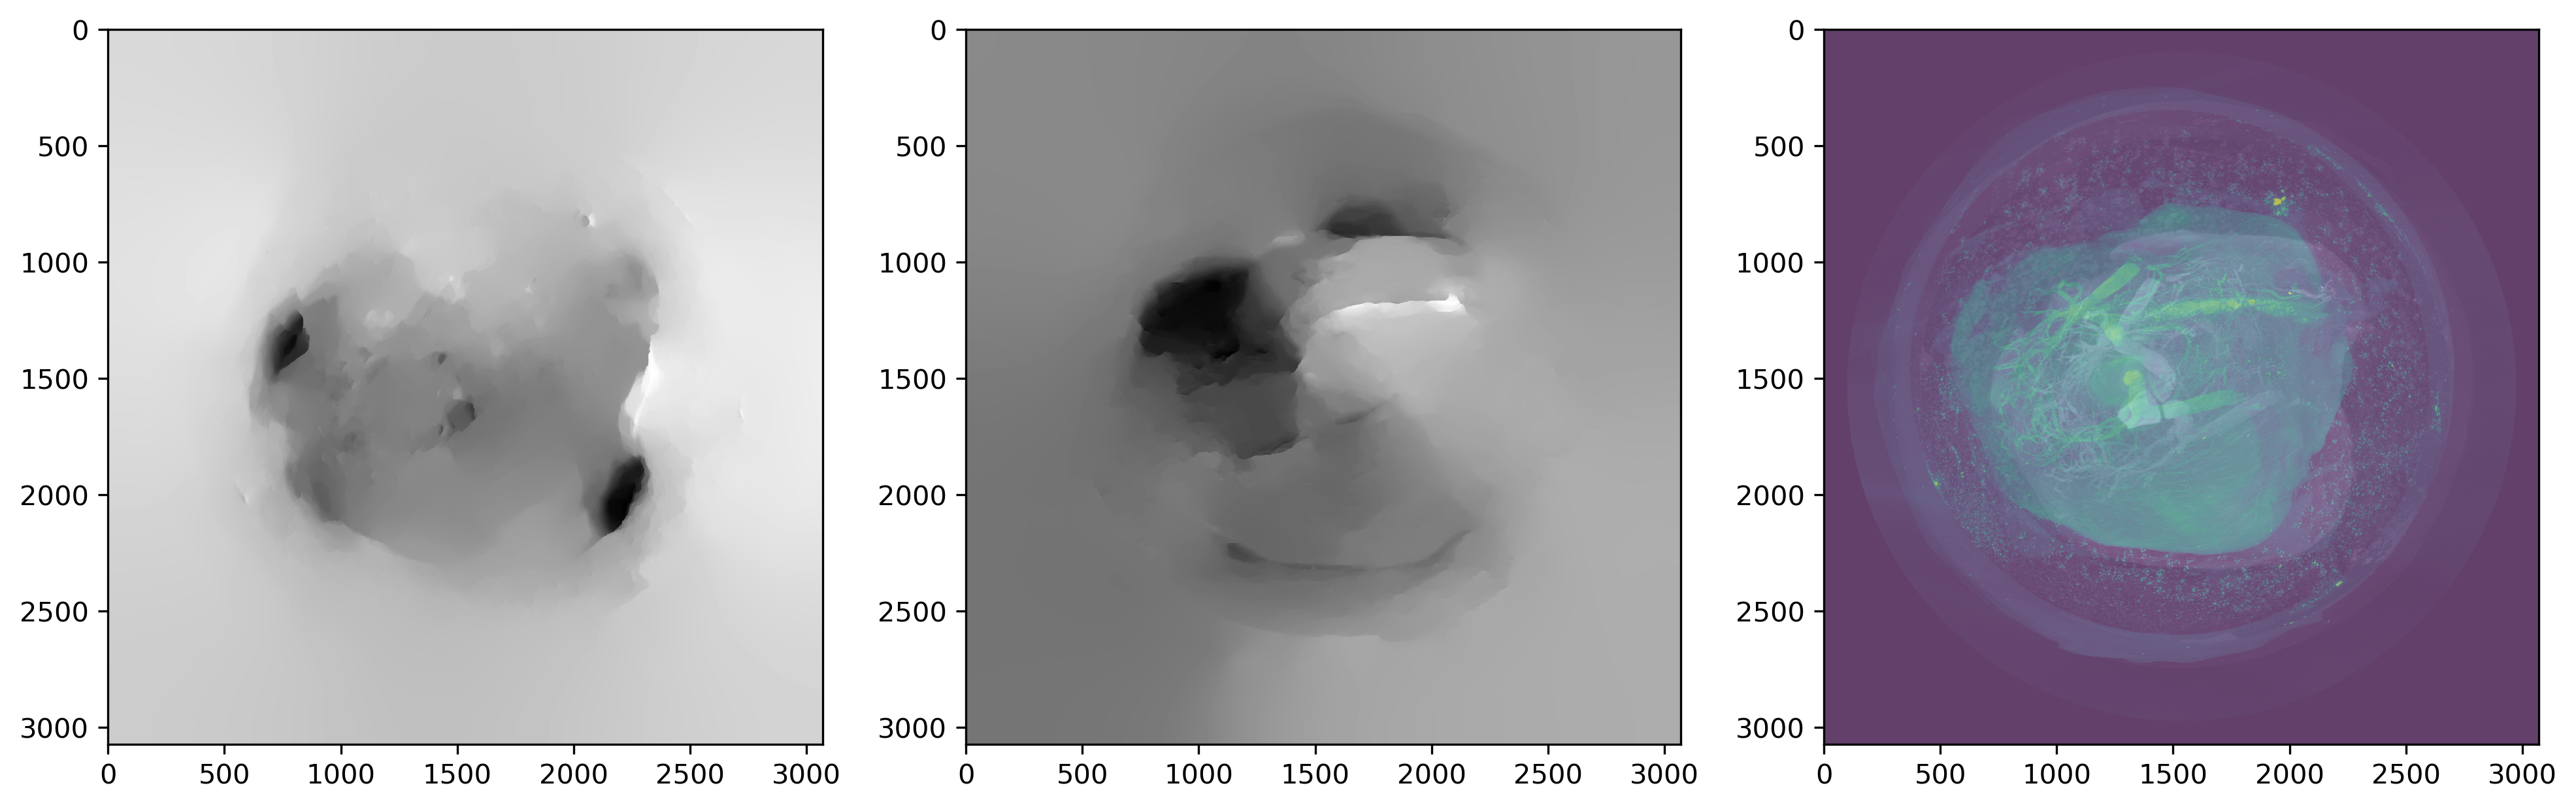

In [54]:
plt.subplot(131)
plt.imshow(u)
plt.subplot(132)
plt.imshow(v)
plt.subplot(133)
plt.imshow(image, alpha=0.5)
plt.imshow(moving_image, alpha=0.5, cmap='viridis')
plt.show()

In [1]:
import pandas as pd
df = pd.read_csv('https://data.cityofchicago.org/resource/uupf-x98q.csv')
df[['LEGAL NAME', 'ZIP CODE', 'BUSINESS ACTIVITY']].head()

,LEGAL NAME,ZIP CODE,BUSINESS ACTIVITY
0,DE LA TORRE AUTO SALES INC.,60621,Motor Vehicle Repair - Engine and Transmissio...
1,SITEL ARM CORP.,33131,Debt Collecting - Administrative Commercial Of...
2,"Energy Resource Specialist, Inc",61523,Roof Repair and Installation
3,"CTA FOODS, INC.",60622,Retail Sales of Packaged Liquor
4,CENVEO WORLDWIDE LIMITED,60618,"Printing Activities, Metal Processing"


In [2]:
zips = df.groupby('ZIP CODE').count()['ID'].sort_values(ascending=False)
zips = list(zips[zips > 20].index)
zips

[60618, 60639, 60622, 60609, 60649, 60655, 60647, 60608, 60619, 60614]

In [3]:
df.loc[df['ZIP CODE'] == zips[0]].sort_values(by='LICENSE TERM EXPIRATION DATE', ascending=False)[['LEGAL NAME', 'ADDRESS', 'LICENSE TERM EXPIRATION DATE']]

,LEGAL NAME,ADDRESS,LICENSE TERM EXPIRATION DATE
4,CENVEO WORLDWIDE LIMITED,3001 N ROCKWELL ST,12/15/2022
624,DSHAH INC.,3333 W BELMONT AVE STOREFRONT 1,12/15/2022
801,BALDI CANDY CO,3323 W NEWPORT AVE 1ST,12/15/2022
798,EL RANCHITO RESTAURANT CORP,2829 N MILWAUKEE AVE 1,12/15/2022
792,STICKY RICE INC.,4018 N WESTERN AVE,12/15/2022
...,...,...,...
148,MARIA R. MOROCHO,3410 W IRVING PARK RD 1ST,11/15/2022
793,LITTLE CREATIVE MINDS CHILD DEVELOPMENT CENTER...,3748 W MONTROSE AVE 1ST,10/15/2022
703,"Synlawn Chicago,LLC",2632 W BARRY AVE,01/15/2023
471,"CUTTING EDGES BEAUTY STUDIO, INC.",2941 W IRVING PARK RD 1,01/15/2023


In [4]:
import ipywidgets as widgets
widgets.Dropdown(
    options=zips,
    value=zips[0],
    description='Zip Code:',
    disabled=False,
)

Dropdown(description='Zip Code:', options=(60618, 60639, 60622, 60609, 60649, 60655, 60647, 60608, 60619, 6061…